# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from copy import deepcopy
from collections import defaultdict
from datetime import datetime

from qscaled.utils.configs import BaseConfig

from scripts.wandb_utils.zip_handler import ModelSizeZipHandler
from scripts.core.preprocess import (
    bootstrap_crossings_per_env,
    fill_isotonic_regression,
    truncate,
    filter_out_resets,
    load_old_bro_data,
)
from scripts.constants import DEFAULT_MAX_STEPS, BASE_THRESHOLDS, THRESHOLD_FILTER

from scripts.core.bootstrapping import (
    insert_predictions_sum_powerlaw,
    predict_sum_of_powerlaw,
    insert_predictions_sum_of_powerlaw_shared_exponent,
    predict_sum_of_powerlaw_shared_exponent,
)

from scripts.experiments.bro_ablations.plot_utils import (
    learning_curves_per_utd,
    compute_data_efficiency_per_env,
    compute_normalized_times,
)

from scripts.experiments.utd_x_width_x_bs import plot_utils


import qscaled

qscaled.constants.QSCALED_PATH = os.path.expanduser('~/.value-scaling')
qscaled.constants.suppress_overwrite_prompt = True

In [3]:
BENCHMARK_NAME = 'dmc'
df = load_old_bro_data(f'{qscaled.constants.QSCALED_PATH}/zip/dmc_bro_ablations.zip').query(
    f'benchmark == "{BENCHMARK_NAME}"'
)

ModelSizeSweepConfig = BaseConfig

config_input_dict = dict(
    max_returns={},
    returns_key='return',
    thresholds=[],
)

config = ModelSizeSweepConfig(
    name=f'old_bro_{BENCHMARK_NAME}',
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)


def linear_threshold_with_base(env, max_thresh):
    return np.linspace(BASE_THRESHOLDS[env], max_thresh, n_thresholds)


n_thresholds = 20
threshold_fn_to_use = linear_threshold_with_base
threshold_description = '_linear20_with_base'

In [4]:
def preprocess(df, config, use_cached, max_threshold_per_env=None):
    truncate_steps = DEFAULT_MAX_STEPS

    df = deepcopy(df)
    df = truncate(df, truncate_steps)
    df = filter_out_resets(df, reset_freq=2.5e6)

    fill_isotonic_regression(
        df,
        training_step_key='training_step_resetfilter',
        mean_return_key='mean_return_resetfilter',
    )

    if max_threshold_per_env is None:
        max_threshold_per_env = (
            df.query(THRESHOLD_FILTER[BENCHMARK_NAME]['threshold_filter'])
            .groupby('env_name')['final_return_isotonic']
            .quantile(0.2)
            .to_dict()
        )
        max_threshold_per_env = {k: (0.95 * v // 10) * 10 for k, v in max_threshold_per_env.items()}

    df, _, thresholds_per_env = bootstrap_crossings_per_env(
        df,
        manual_thresholds=max_threshold_per_env,
        max_threshold_to_thresholds_fn=threshold_fn_to_use,
        training_step_key='training_step_resetfilter',
        return_key='return_resetfilter',
        filename=config.name,
        use_cached=use_cached,
    )

    df['mean_return_over_training'] = df['return'].apply(lambda x: np.mean(x))
    df['std_return_over_training'] = df['return'].apply(
        lambda x: x.mean(axis=0).std() / np.sqrt(x.shape[1])
    )
    return df, max_threshold_per_env, thresholds_per_env


df, max_threshold_per_env, thresholds_per_env = preprocess(df, config, use_cached=True)

100%|██████████| 175/175 [00:12<00:00, 13.94it/s]

It is likely that some environments do not reach every performance threshold for every UTD. This can cause the standard deviation to be zero. Consider decreasing your thresholds in the config, and call `bootstrap_crossings` with `use_cached=False`. <class 'UserWarning'>
Average standard deviation across all conditions: 32875.77


In [5]:
max_threshold_per_env

{'acrobot-swingup': 400.0,
 'cheetah-run': 750.0,
 'finger-turn': 900.0,
 'fish-swim': 710.0,
 'hopper-hop': 320.0,
 'quadruped-run': 790.0,
 'walker-run': 730.0}

# Learning curves

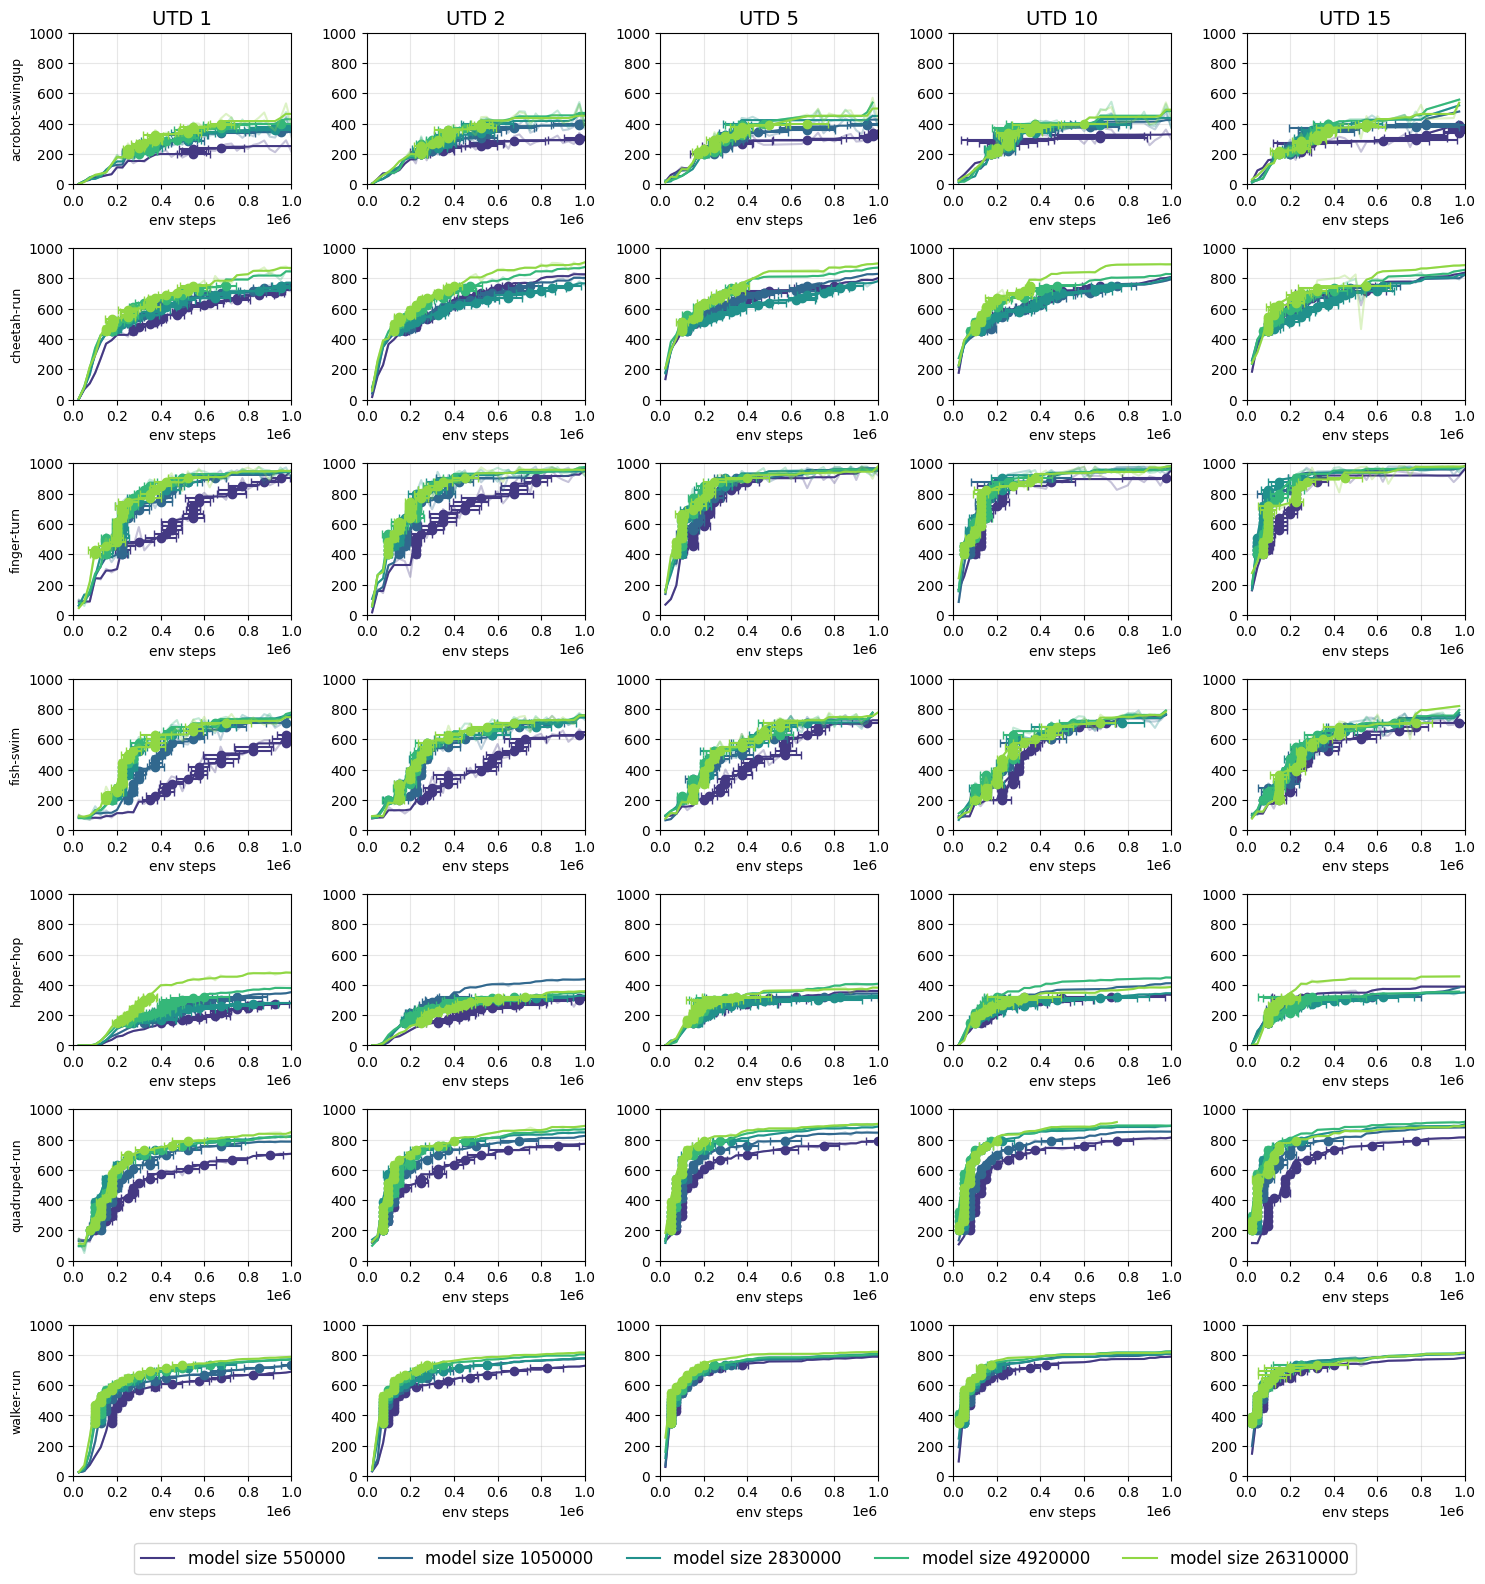

In [6]:
learning_curves_per_utd(df, ylabel_fontsize=9)

# Data efficiency fit

In [7]:
xcols = ['utd', 'critic_params']
df['critic_params'] = df['model_size']
df['last_crossing'] = df['crossings'].apply(lambda x: x[-1])
df['last_crossing_std'] = df['crossings_std'].apply(lambda x: x[-1])
fit_df = df.dropna(subset=['last_crossing'])

filtered_df = fit_df.query(THRESHOLD_FILTER[BENCHMARK_NAME]['threshold_filter'])


def make_multiple_crossings_df(df):
    df = deepcopy(df)
    multiple_crossings_df = df[
        ['env_name', 'critic_params', 'utd', 'crossings', 'crossings_bootstrap']
    ]

    multiple_crossings_df = multiple_crossings_df.sort_values(
        ['env_name', 'utd', 'critic_params']
    ).reset_index(drop=True)

    for i in range(n_thresholds):
        multiple_crossings_df[f'crossing{i}'] = multiple_crossings_df['crossings'].apply(
            lambda x: x[i]
        )
        multiple_crossings_df[f'crossing{i}_std'] = multiple_crossings_df[
            'crossings_bootstrap'
        ].apply(lambda x: np.nanstd(x, axis=0)[i])
    multiple_crossings_df['time_to_threshold'] = multiple_crossings_df[
        f'crossing{n_thresholds - 1}'
    ]
    return multiple_crossings_df


generic_fit_infos = {
    'sum_of_powerlaw_shared_exp': {
        'color': 'darkturquoise',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha}} + \dfrac{b_{\text{env}}}{N^{\beta}}$',
    },
}

multiple_crossings_df = make_multiple_crossings_df(df)
time_to_thresholds_predictors = [{} for _ in range(n_thresholds)]
time_to_thresholds_infos_utd = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]
time_to_thresholds_infos_n = [deepcopy(generic_fit_infos) for _ in range(n_thresholds)]

multiple_crossings_state = (
    multiple_crossings_df,
    time_to_thresholds_predictors,
    time_to_thresholds_infos_utd,
    time_to_thresholds_infos_n,
)

/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees

In [8]:
def insert_multiple_sum_powerlaw_shared_exp(state, config, use_cached):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_of_powerlaw_shared_exp'
    kw = dict(use_cached=True, log_loss=False)

    for i in range(n_thresholds):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_shared_exponent_params = (
            insert_predictions_sum_of_powerlaw_shared_exponent(
                multiple_crossings_df,
                xcols,
                f'crossing{i}',
                name=f'{config.name}_crossing{i}',
                **kw,
            )
        )

        predict_data_efficiency_sum_powerlaw_shared_exponent_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw_shared_exponent(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_shared_exponent_params)

        data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
            for utd in set(df['utd'].unique())  # | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_shared_exponent_params.items()
            for n in set(df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_shared_exponent_
        infos_utd[i][fit_type]['asymptote'] = (
            data_efficiency_sum_powerlaw_shared_exponent_asymptotes_utd
        )
        infos_n[i][fit_type]['asymptote'] = (
            data_efficiency_sum_powerlaw_shared_exponent_asymptotes_n
        )
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_shared_exponent_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_shared_exponent_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


multiple_crossings_state = insert_multiple_sum_powerlaw_shared_exp(
    multiple_crossings_state, config, use_cached=True
)

Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_crossing0/utd_critic_params_crossing0_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_crossing1/utd_critic_params_crossing1_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_crossing2/utd_critic_params_crossing2_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_crossing3/utd_critic_params_crossing3_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_crossing4/utd_critic_params_crossing4_sum_of_powerlaw_shared_exp_no_log_loss.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_crossing5/utd

In [9]:
def compute_multiple_optimal_budget(multiple_crossings_df, infos, delta_dict, use_cached):
    results = []
    for env, group in multiple_crossings_df.groupby('env_name'):
        delta_str = delta_dict[env]

        cache_file = f'budget_optimal/{config.name}/multiple_budget_optimal_hparams_{env}_{delta_str}_250514.csv'
        if use_cached and os.path.exists(cache_file):
            env_hparams = pd.read_csv(cache_file)
        else:
            env_hparams = plot_utils.compute_optimal_budget(
                group,
                params_per_thresh=[
                    infos[i]['sum_of_powerlaw_shared_exp']['params'] for i in range(n_thresholds)
                ],
                data_efficiency_key_prefix='crossing',
                delta=float(delta_str),
            )
        results.append(env_hparams)
    return pd.concat(results)


delta_dict = defaultdict(lambda: '1e11')

multiple_budget_optimal_hparams = compute_multiple_optimal_budget(
    multiple_crossings_df,
    time_to_thresholds_infos_utd,
    delta_dict,
    use_cached=True,
)

100%|██████████| 20/20 [00:00<00:00, 508.74it/s]


100%|██████████| 20/20 [00:00<00:00, 453.75it/s]


In [10]:
multiple_budget_optimal_hparams_with_fit = plot_utils.insert_budget_fitted_hparams(
    multiple_budget_optimal_hparams,
    params_per_thresh=[
        time_to_thresholds_infos_utd[i]['sum_of_powerlaw_shared_exp']['params']
        for i in range(n_thresholds)
    ],
)

/home/preston/model-scaling-minimal/scripts/core/fitting.py:846: RuntimeWarning: invalid value encountered in divide
  x_scaled = np.exp((np.log(x) - m) / s)
/home/preston/model-scaling-minimal/scripts/core/fitting.py:846: RuntimeWarning: invalid value encountered in divide
  x_scaled = np.exp((np.log(x) - m) / s)


## Figure 6 analog

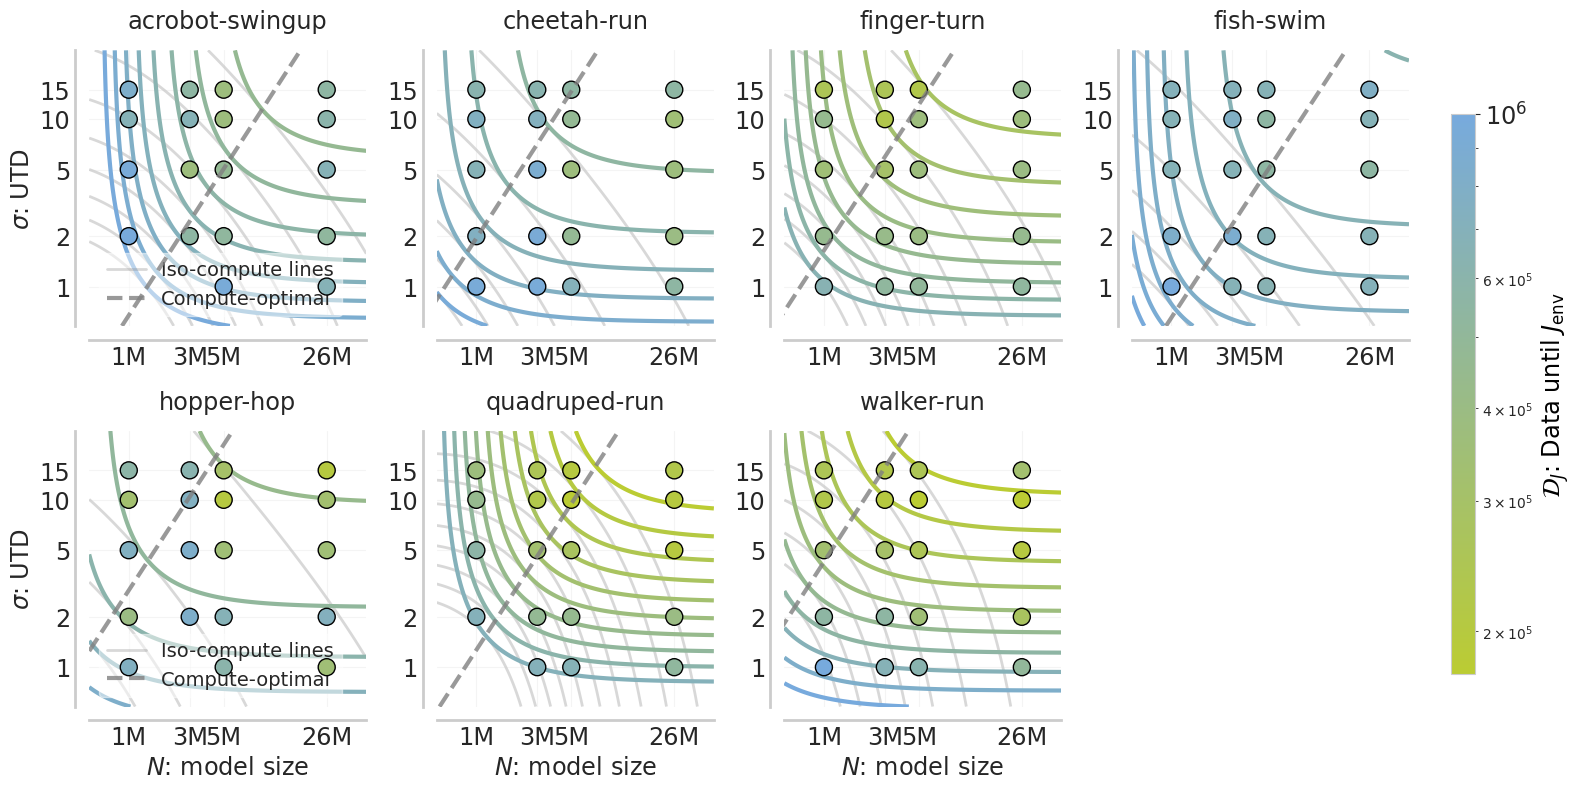

In [11]:
_ = plot_utils.plot_optimal_hparams_scatter_pretty(
    filtered_df,
    multiple_crossings_state[1][-1]['sum_of_powerlaw_shared_exp'],
    'last_crossing',
    mode='data_contour',
)

## Figures 18, 19: Budget-optimal data-compute allocation

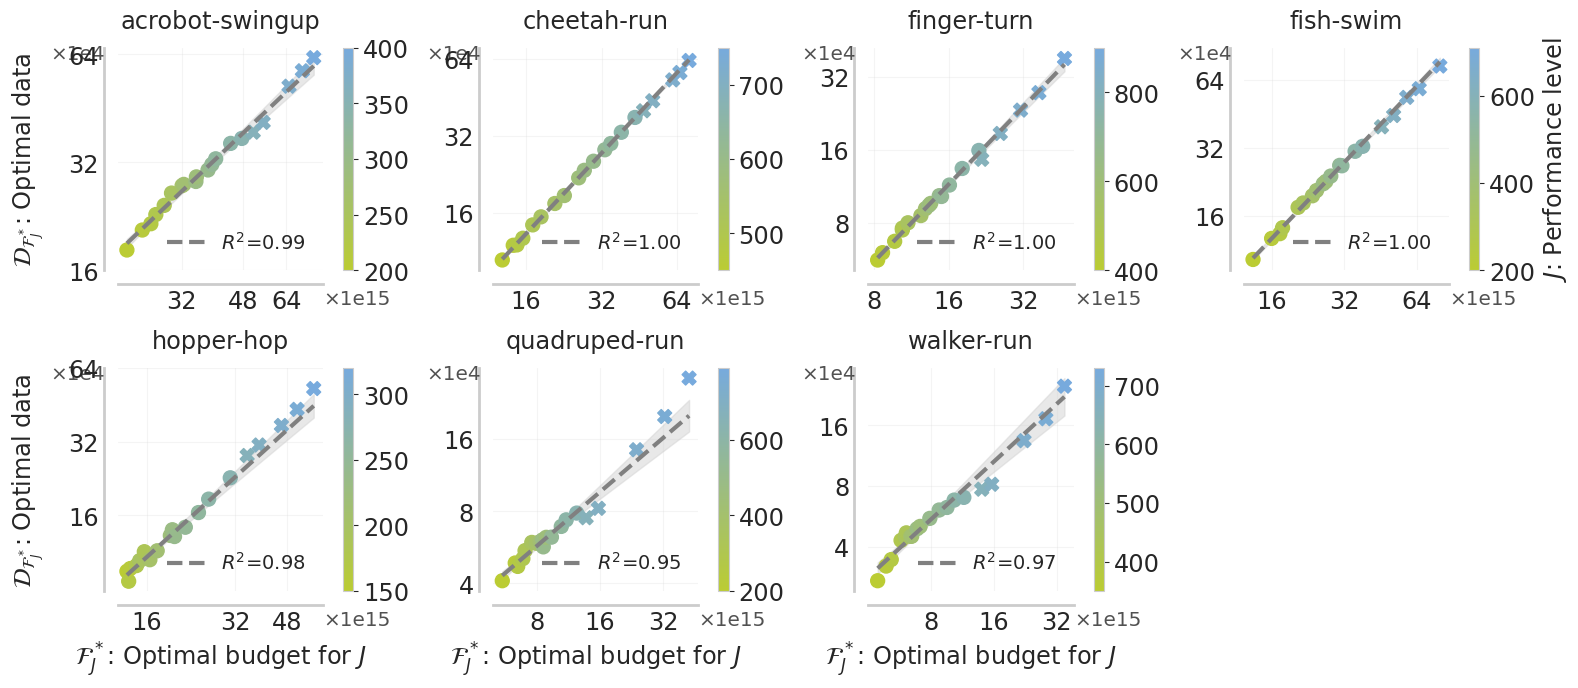

In [12]:
plot_utils.plot_budget_data_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'acrobot-swingup': [32e15, 48e15, 64e15],
        'cheetah-run': [16e15, 32e15, 64e15],
        'finger-turn': [8e15, 16e15, 32e15],
        'fish-swim': [16e15, 32e15, 64e15],
        'hopper-hop': [16e15, 32e15, 48e15],
        'quadruped-run': [8e15, 16e15, 32e15],
        'walker-run': [8e15, 16e15, 32e15],
    },
    xscale='1e15',
    data_yticks={
        'acrobot-swingup': [16e4, 32e4, 64e4],
        'cheetah-run': [16e4, 32e4, 64e4],
        'finger-turn': [8e4, 16e4, 32e4],
        'fish-swim': [16e4, 32e4, 64e4],
        'hopper-hop': [16e4, 32e4, 64e4],
        'quadruped-run': [4e4, 8e4, 16e4],
        'walker-run': [4e4, 8e4, 16e4],
    },
    data_yscale='1e4',
    num_extrapolated_points=5,
)

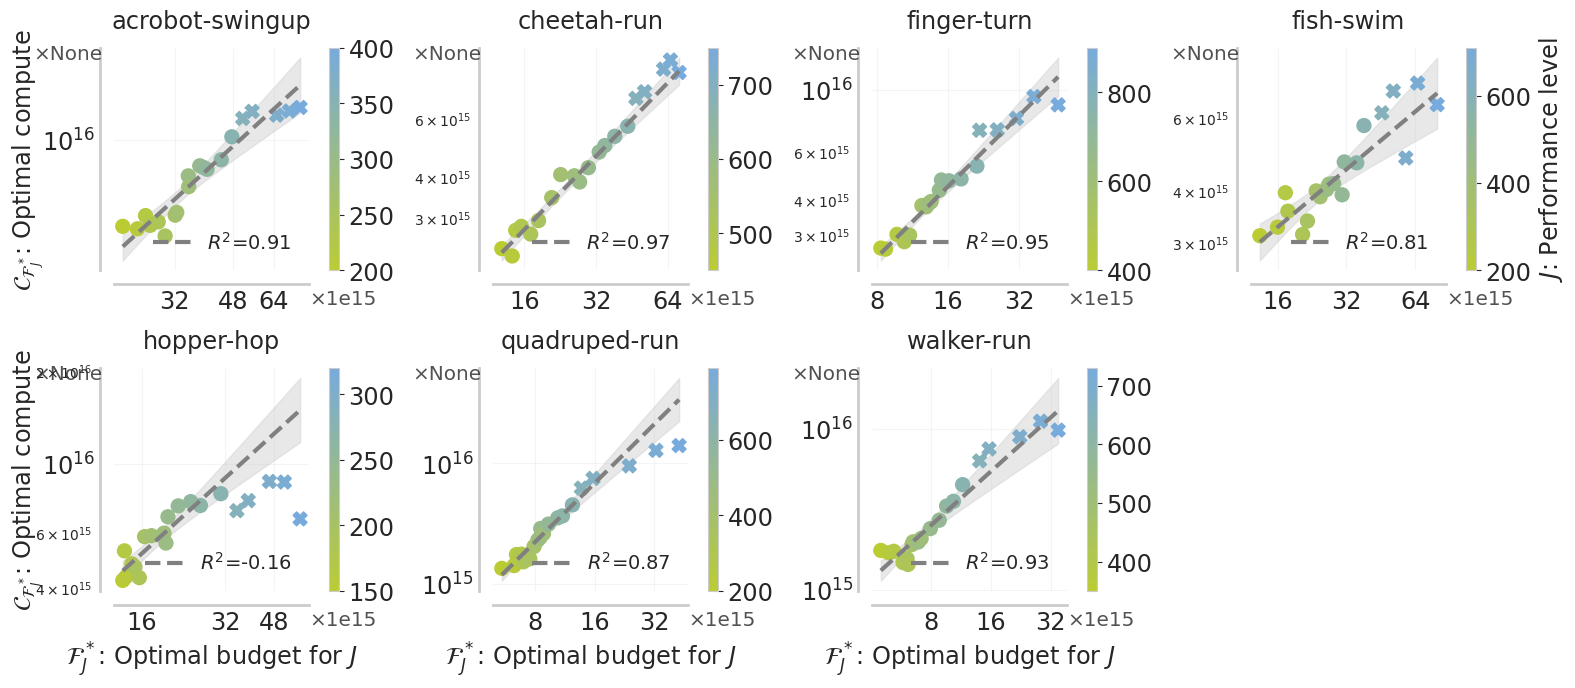

In [13]:
plot_utils.plot_budget_compute_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'acrobot-swingup': [32e15, 48e15, 64e15],
        'cheetah-run': [16e15, 32e15, 64e15],
        'finger-turn': [8e15, 16e15, 32e15],
        'fish-swim': [16e15, 32e15, 64e15],
        'hopper-hop': [16e15, 32e15, 48e15],
        'quadruped-run': [8e15, 16e15, 32e15],
        'walker-run': [8e15, 16e15, 32e15],
    },
    xscale='1e15',
    num_extrapolated_points=5,
)

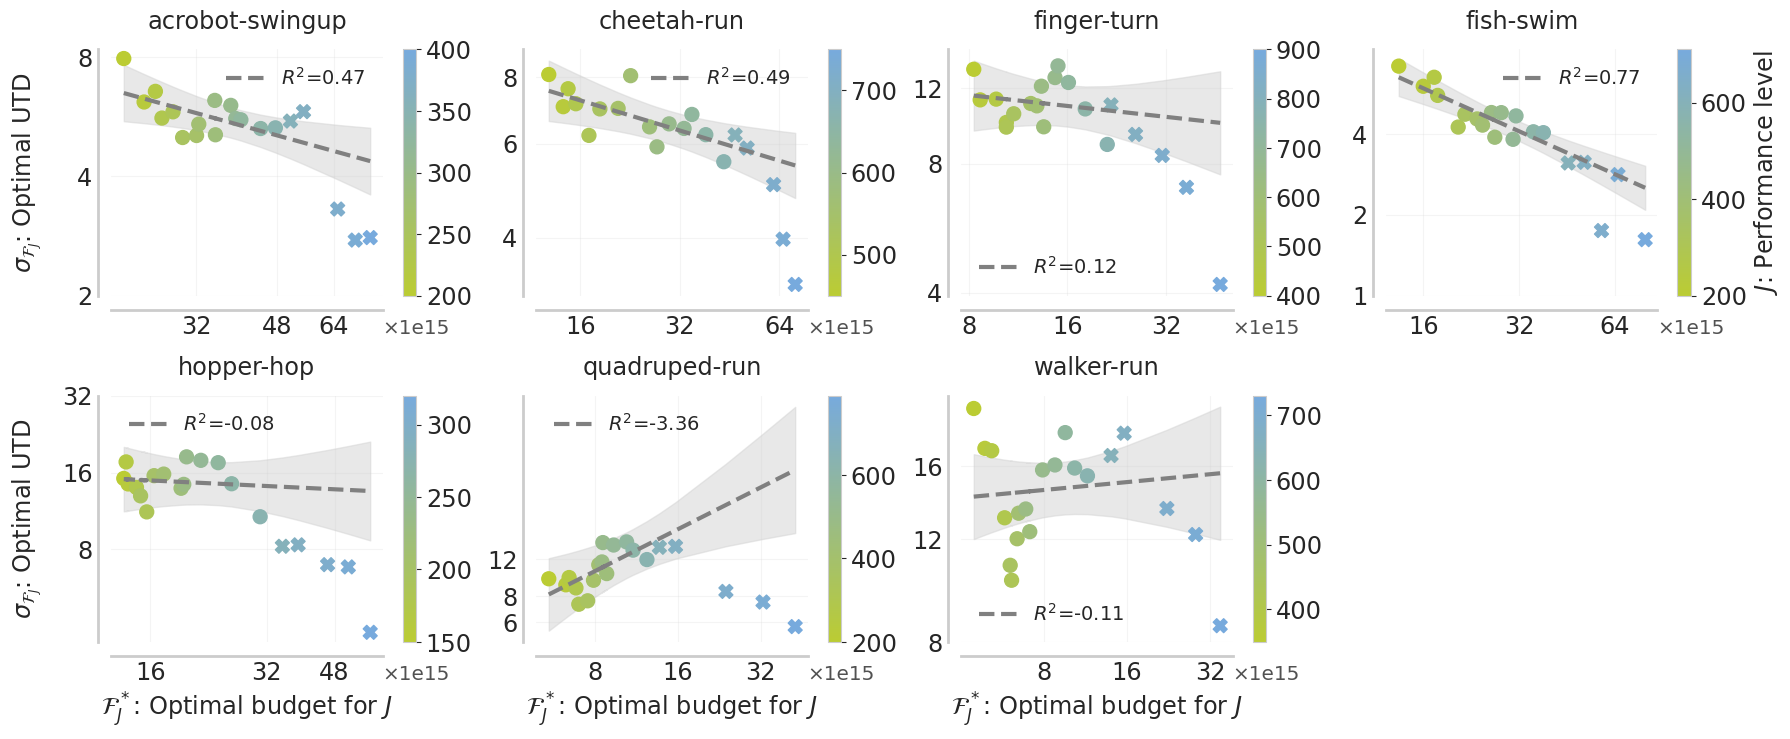

In [14]:
plot_utils.plot_budget_sigma_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'acrobot-swingup': [32e15, 48e15, 64e15],
        'cheetah-run': [16e15, 32e15, 64e15],
        'finger-turn': [8e15, 16e15, 32e15],
        'fish-swim': [16e15, 32e15, 64e15],
        'hopper-hop': [16e15, 32e15, 48e15],
        'quadruped-run': [8e15, 16e15, 32e15],
        'walker-run': [8e15, 16e15, 32e15],
    },
    xscale='1e15',
    sigma_yticks={
        'acrobot-swingup': [2, 4, 8],
        'cheetah-run': [4, 6, 8],
        'finger-turn': [4, 8, 12],
        'fish-swim': [1, 2, 4],
        'hopper-hop': [8, 16, 32],
        'quadruped-run': [6, 8, 12],
        'walker-run': [8, 12, 16],
    },
    sigma_yscale='1',
    num_extrapolated_points=5,
)

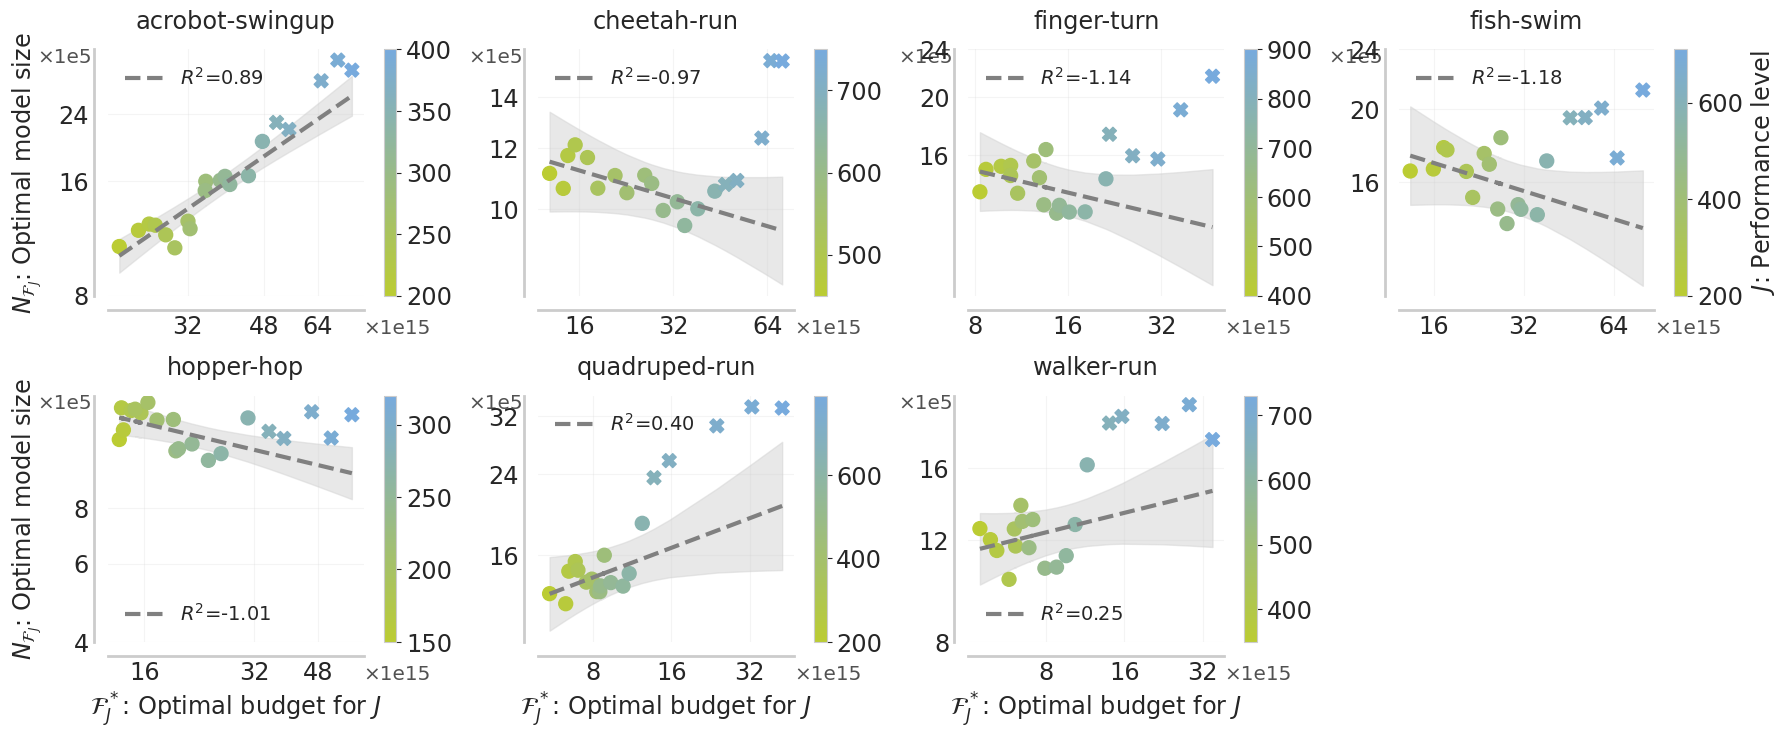

In [15]:
plot_utils.plot_budget_n_opt_pretty(
    multiple_budget_optimal_hparams_with_fit,
    delta_dict,
    thresholds_per_env,
    xticks={
        'acrobot-swingup': [32e15, 48e15, 64e15],
        'cheetah-run': [16e15, 32e15, 64e15],
        'finger-turn': [8e15, 16e15, 32e15],
        'fish-swim': [16e15, 32e15, 64e15],
        'hopper-hop': [16e15, 32e15, 48e15],
        'quadruped-run': [8e15, 16e15, 32e15],
        'walker-run': [8e15, 16e15, 32e15],
    },
    xscale='1e15',
    n_yticks={
        'acrobot-swingup': [8e5, 16e5, 24e5],
        'cheetah-run': [10e5, 12e5, 14e5],
        'finger-turn': [16e5, 20e5, 24e5],
        'fish-swim': [16e5, 20e5, 24e5],
        'hopper-hop': [4e5, 6e5, 8e5],
        'quadruped-run': [16e5, 24e5, 32e5],
        'walker-run': [8e5, 12e5, 16e5],
    },
    n_yscale='1e5',
    num_extrapolated_points=5,
)

# Averaged over tasks

## Data efficiency fit

In [16]:
env_data_efficiency_dict = compute_data_efficiency_per_env(filtered_df)
normalized_times_all, mean_normalized_times, median_median = compute_normalized_times(
    env_data_efficiency_dict, filtered_df, n_thresholds
)
std_normalized_times = np.std(normalized_times_all, axis=0)

no data for ('acrobot-swingup', 1, 1050000)
no data for ('acrobot-swingup', 1, 2830000)
no data for ('hopper-hop', 1, 2830000)
no data for ('quadruped-run', 1, 1050000)


In [17]:
def make_averaged_threshold_dfs(df, mean_normalized_times, median_median):
    utds = sorted(df['utd'].unique())
    model_sizes = sorted(df['model_size'].unique())
    threshold_dfs = []

    for threshold_idx in range(mean_normalized_times.shape[2]):
        datas = []
        for i, utd in enumerate(utds):
            for j, model_size in enumerate(model_sizes):
                time = median_median * mean_normalized_times[i, j, threshold_idx]
                time_std = median_median * std_normalized_times[i, j, threshold_idx]
                datas.append([utd, model_size, time, time_std])
        threshold_df = pd.DataFrame(datas, columns=['utd', 'critic_params', 'time', 'time_std'])
        threshold_df['env_name'] = ''
        threshold_dfs.append(threshold_df)

    return threshold_dfs


def make_averaged_threshold_fits(threshold_dfs, use_cached=True):
    predict_fns = []
    params_sets = []
    asymptotes_per_utd = []
    asymptotes_per_model_size = []

    for threshold_idx, threshold_df in enumerate(threshold_dfs):
        # sum powerlaw
        threshold_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            threshold_df,
            ['utd', 'critic_params'],
            'time',
            name=f'{config.name}_averaged_threshold{threshold_idx}',
            use_cached=use_cached,
            log_loss=True,
        )

        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: lambda df: predict_sum_of_powerlaw(df, xcols, params)
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in df['utd'].unique()
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in df['critic_params'].unique()
        }

        threshold_dfs[threshold_idx] = threshold_df
        predict_fns.append(
            {
                'sum_powerlaw': predict_data_efficiency_sum_powerlaw_,
            }
        )
        params_sets.append({'sum_powerlaw': time_to_thresh_sum_powerlaw_params})
        asymptotes_per_utd.append({'sum_powerlaw': data_efficiency_sum_powerlaw_asymptotes_utd})
        asymptotes_per_model_size.append(
            {'sum_powerlaw': data_efficiency_sum_powerlaw_asymptotes_n}
        )

    return threshold_dfs, predict_fns, params_sets, asymptotes_per_utd, asymptotes_per_model_size


averaged_threshold_dfs = make_averaged_threshold_dfs(
    filtered_df, mean_normalized_times, median_median
)
(
    averaged_threshold_dfs,
    averaged_predict_fns,
    averaged_params_sets,
    averaged_asymptotes_per_utd,
    averaged_asymptotes_per_model_size,
) = make_averaged_threshold_fits(averaged_threshold_dfs, use_cached=False)

Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_threshold0/utd_critic_params_time_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_threshold1/utd_critic_params_time_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_threshold2/utd_critic_params_time_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_threshold3/utd_critic_params_time_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_threshold4/utd_critic_params_time_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_threshold5/utd_critic_params_time_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/script

In [18]:
def compute_multiple_optimal_budget(multiple_crossings_df, infos, delta_dict, use_cached):
    results = []
    for env, group in multiple_crossings_df.groupby('env_name'):
        delta_str = delta_dict[env]

        cache_file = f'budget_optimal/{config.name}/multiple_budget_optimal_hparams_{env}_{delta_str}_250514.csv'
        if use_cached and os.path.exists(cache_file):
            env_hparams = pd.read_csv(cache_file)
        else:
            env_hparams = plot_utils.compute_optimal_budget(
                group,
                params_per_thresh=[infos[i]['sum_powerlaw']['params'] for i in range(n_thresholds)],
                data_efficiency_key_prefix='crossing',
                delta=float(delta_str),
            )
        results.append(env_hparams)
    return pd.concat(results)

In [19]:
time = datetime.now().strftime('%y%m%d_%H%M%S')
output_file = f'../dump/{config.name}_averaged/last_threshold_{time}.csv'
print(output_file)
os.makedirs(os.path.dirname(output_file), exist_ok=True)
averaged_threshold_dfs[-1].to_csv(output_file, index=False)

../dump/old_bro_dmc_averaged/last_threshold_250903_161612.csv


In [20]:
def make_averaged_multiple_crossings_df(averaged_threshold_dfs):
    df = averaged_threshold_dfs[0][['env_name', 'utd', 'critic_params']]
    for i in range(n_thresholds):
        df[f'crossing{i}'] = averaged_threshold_dfs[i]['time']
        df[f'crossing{i}_std'] = averaged_threshold_dfs[i]['time_std']
    return df


averaged_multiple_crossings_df = make_averaged_multiple_crossings_df(averaged_threshold_dfs)
averaged_config = deepcopy(config)
averaged_config.name += '_averaged'

averaged_generic_fit_infos = {
    'sum_powerlaw': {
        'color': 'tab:purple',
        'label': r'$D \sim D_{\text{min}}^{\text{env}} + \dfrac{a_{\text{env}}}{\sigma^{\alpha_{\text{env}}}} + \dfrac{b_{\text{env}}}{N^{\beta_{\text{env}}}}$',
    },
}

averaged_time_to_thresholds_predictors = [{} for _ in range(n_thresholds)]
averaged_time_to_thresholds_infos_utd = [
    deepcopy(averaged_generic_fit_infos) for _ in range(n_thresholds)
]
averaged_time_to_thresholds_infos_n = [
    deepcopy(averaged_generic_fit_infos) for _ in range(n_thresholds)
]

averaged_multiple_crossings_state = (
    averaged_multiple_crossings_df,
    averaged_time_to_thresholds_predictors,
    averaged_time_to_thresholds_infos_utd,
    averaged_time_to_thresholds_infos_n,
)

In [21]:
def insert_multiple_sum_powerlaw(state, config):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_powerlaw'
    kw = dict(use_cached=True, log_loss=True)

    for i in range(n_thresholds):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            multiple_crossings_df, xcols, f'crossing{i}', name=f'{config.name}_crossing{i}', **kw
        )

        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in set(df['utd'].unique())  # | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in set(
                df['critic_params'].unique()
            )  # | set(extrapolated_bs_df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_
        infos_utd[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_utd
        infos_n[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_n
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


def insert_multiple_sum_powerlaw(state, config):
    (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    ) = state

    fit_type = 'sum_powerlaw'
    kw = dict(use_cached=True, log_loss=True)

    for i in range(n_thresholds):
        multiple_crossings_df, time_to_thresh_sum_powerlaw_params = insert_predictions_sum_powerlaw(
            multiple_crossings_df, xcols, f'crossing{i}', name=f'{config.name}_crossing{i}', **kw
        )

        predict_data_efficiency_sum_powerlaw_ = (
            lambda params: (lambda df: predict_sum_of_powerlaw(df, xcols, params))
        )(time_to_thresh_sum_powerlaw_params)

        data_efficiency_sum_powerlaw_asymptotes_utd = {
            (k, utd): params[4] * (1 + (params[0] / utd) ** params[1])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for utd in set(df['utd'].unique())  # | set(extrapolated_bs_df['utd'].unique())
        }

        data_efficiency_sum_powerlaw_asymptotes_n = {
            (k, n): params[4] * (1 + (params[2] / n) ** params[3])
            for k, params in time_to_thresh_sum_powerlaw_params.items()
            for n in set(
                df['critic_params'].unique()
            )  # | set(extrapolated_bs_df['critic_params'].unique())
        }

        predictors[i][fit_type] = predict_data_efficiency_sum_powerlaw_
        infos_utd[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_utd
        infos_n[i][fit_type]['asymptote'] = data_efficiency_sum_powerlaw_asymptotes_n
        infos_utd[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params
        infos_n[i][fit_type]['params'] = time_to_thresh_sum_powerlaw_params

    return (
        multiple_crossings_df,
        predictors,
        infos_utd,
        infos_n,
    )


averaged_multiple_crossings_state = insert_multiple_sum_powerlaw(
    averaged_multiple_crossings_state, averaged_config
)

Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_crossing0/utd_critic_params_crossing0_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_crossing1/utd_critic_params_crossing1_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_crossing2/utd_critic_params_crossing2_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_crossing3/utd_critic_params_crossing3_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_crossing4/utd_critic_params_crossing4_sum_powerlaw.npy
Saved params to /home/preston/model-scaling-minimal/scripts/core/../experiments/fits/old_bro_dmc_averaged_crossing5/utd_critic_params_crossing5_sum_powerlaw.npy
Saved params to /home/preston/mode

In [22]:
averaged_multiple_budget_optimal_hparams = compute_multiple_optimal_budget(
    averaged_multiple_crossings_df,
    averaged_time_to_thresholds_infos_utd,
    delta_dict={'': '1e11'},
    use_cached=True,
)
averaged_multiple_budget_optimal_hparams['env_name'] = ''

100%|██████████| 20/20 [00:00<00:00, 466.61it/s]


## Subset of Figure 6

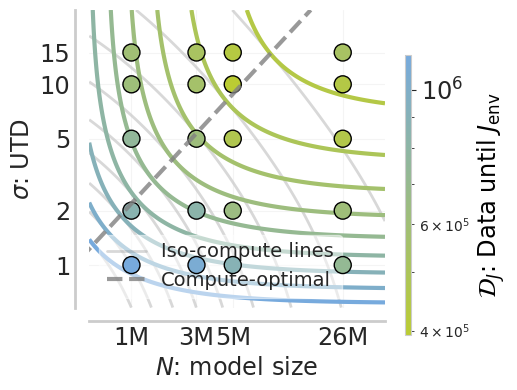

In [23]:
averaged_data_optimal_hparams = plot_utils.plot_optimal_hparams_scatter_pretty(
    averaged_threshold_dfs[-1],
    averaged_predict_fns[-1]['sum_powerlaw'],
    'time',
    mode='data_contour',
    col_width=4.5,
)